# Load data

In [1]:
import pandas as pd
from pathlib import Path

base_folder = Path.cwd()


sample_files = ['sample_1.csv', 'sample_2.csv', 'sample_3.csv', 'sample_4.csv']
data = {}

for folder in [f for f in base_folder.iterdir() if f.is_dir()]:
    data[folder.name] = {}
    for sample_file in sample_files:
        file_path = folder / sample_file
        if file_path.exists():
            df = pd.read_csv(file_path, encoding='utf-8-sig')  # handles BOM if present
            # Normalize column names: strip spaces and BOM, unify case
            df.columns = df.columns.str.strip().str.replace('\ufeff', '', regex=True)
            data[folder.name][sample_file] = df


# Containers for data and weights
data = {}
weights = {}

# Helper function to read weights.txt into a dictionary
def read_weights(file_path):
    w = {}
    with open(file_path, 'r') as f:
        for line in f:
            if ";" in line:
                key, value = line.strip().split(";")
                key = key.strip().lower().replace("sample", "sample_") + ".csv"
                value = float(value.strip().replace("grams", "").strip())
                w[key] = value
    return w

# First, load healthy dataset weights for delta comparison
healthy_folder = base_folder / "healthydataset"
healthy_weights = read_weights(healthy_folder / "weights.txt")

# Now process all folders
for folder in [f for f in base_folder.iterdir() if f.is_dir()]:
    folder_name = folder.name
    data[folder_name] = {}
    weights[folder_name] = {}
    
    # Read weights
    weight_file = folder / "weights.txt"
    if weight_file.exists():
        current_weights = read_weights(weight_file)
        for sample_file in sample_files:
            if sample_file in current_weights:
                delta = current_weights[sample_file] - healthy_weights.get(sample_file, 0.0)
                weights[folder_name][sample_file] = delta
    
    # Read sample data
    for sample_file in sample_files:
        file_path = folder / sample_file
        if file_path.exists():
            df = pd.read_csv(file_path, encoding='utf-8-sig')
            df.columns = df.columns.str.strip().str.replace('\ufeff', '', regex=True)
            data[folder_name][sample_file] = df


# PLOT DATA

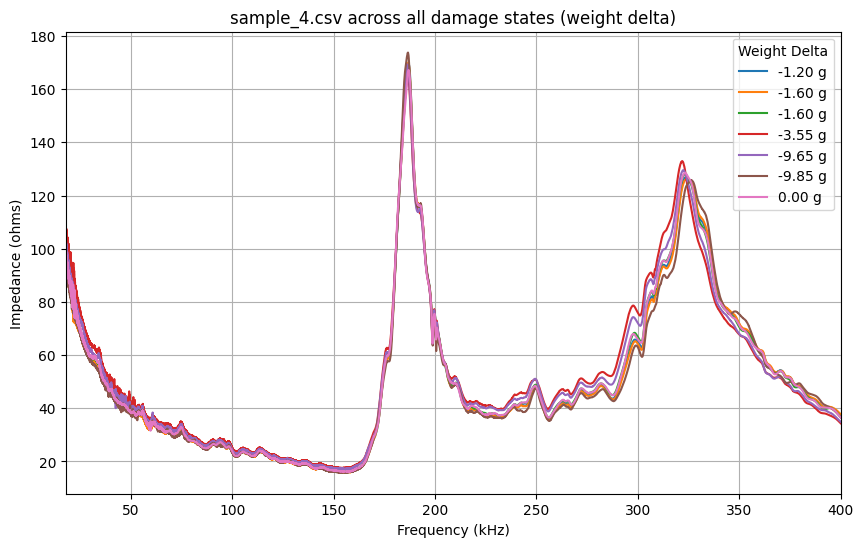

In [2]:
import matplotlib.pyplot as plt

sample_to_plot = "sample_4.csv"

plt.figure(figsize=(10, 6))

for folder_name, samples in data.items():
    if sample_to_plot in samples:
        df = samples[sample_to_plot]
        # Get the delta weight label, format nicely (e.g. 2 decimals)
        delta_weight = weights.get(folder_name, {}).get(sample_to_plot, None)
        label = f"{delta_weight:.2f} g" if delta_weight is not None else folder_name
        
        plt.plot(
            df["Frequency (Hz)"]/1000,
            df["Impedance (ohms)"],
            label=label
        )

plt.xlabel("Frequency (kHz)")
plt.ylabel("Impedance (ohms)")
plt.title(f"{sample_to_plot} across all damage states (weight delta)")
plt.legend(title="Weight Delta")
plt.grid(True)
plt.xlim(18,400)
plt.show()


# PLOT EQUIVALENT CIRCUIT

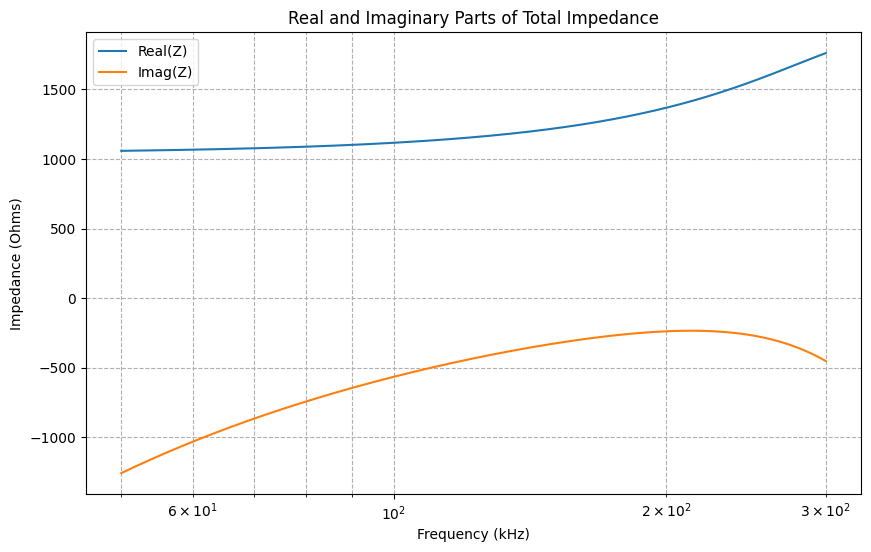

In [3]:
import numpy as np

# Component values
C0 = 260.38e-12  # pFarads
L1 = 587.63e-6  # uHenrys
C1 = 2.18e-9  # nFarads
R1 = 1302     # Ohms

# Frequency range
start_freq = 50_000   # 50 kHz
end_freq = 300_000    # 400 kHz
num_points = 500

f = np.logspace(np.log10(start_freq), np.log10(end_freq), num_points)

omega = 2 * np.pi * f

# Impedances
Z_C0 = 1 / (1j * omega * C0)
Z_series = R1 + 1j * omega * L1 - 1j / (omega * C1)

# Total impedance of parallel combination
Z_total = 1 / (1 / Z_C0 + 1 / Z_series)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(f/1000, Z_total.real, label='Real(Z)')
plt.plot(f/1000, Z_total.imag, label='Imag(Z)')
plt.xscale('log')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Impedance (Ohms)')
plt.title('Real and Imaginary Parts of Total Impedance')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.show()


# First fit attempt

Fitted parameters (band):
C0 = 5.2975e-09 F
L1 = 2.2245e-03 H
C1 = 9.7941e-07 F
R1 = 1981.04 Ω


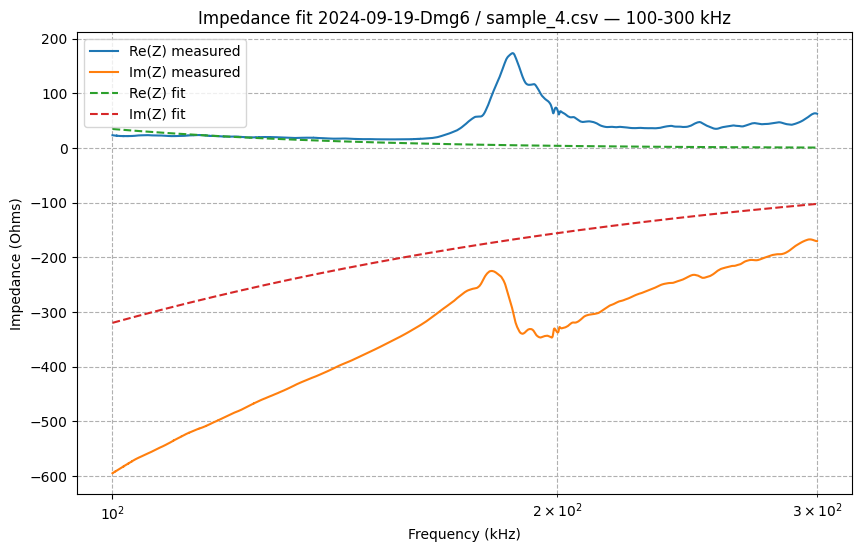

RMSE Real: 4.9360e+01 Ω
RMSE Imag: 1.5100e+02 Ω
R² Real: -1.6551
R² Imag: -0.9769


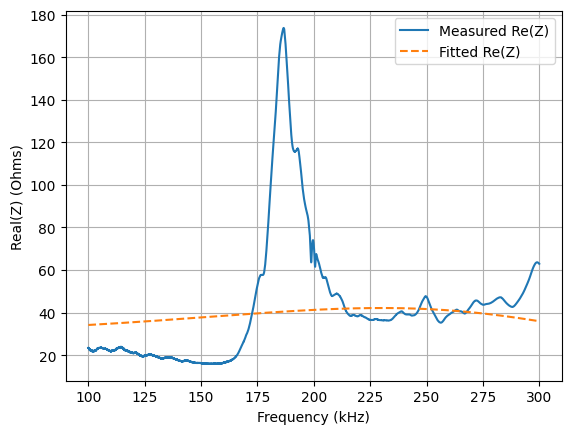

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# ----- Circuit model -----
def impedance_model(f, C0, L1, C1, R1):
    w = 2 * np.pi * f
    Z_C0 = 1.0 / (1j * w * C0)
    Z_series = R1 + 1j * w * L1 - 1j / (w * C1)
    Z_total = 1.0 / (1.0 / Z_C0 + 1.0 / Z_series)
    return Z_total

# ----- Residual builders -----
def residuals_complex(params, f, Z_meas, weights=None):
    Z_pred = impedance_model(f, *params)
    r = np.concatenate([(Z_pred.real - Z_meas.real), (Z_pred.imag - Z_meas.imag)])
    if weights is not None:
        r[:len(f)] *= weights
        r[len(f):] *= weights
    return r

def residuals_magnitude(params, f, Zmag_meas, weights=None):
    Z_pred = impedance_model(f, *params)
    r = np.abs(Z_pred) - Zmag_meas
    if weights is not None:
        r *= weights
    return r

# ----- Parse impedance from DF -----
def get_frequency_and_impedance(df):
    f = df["Frequency (Hz)"].to_numpy(dtype=float)
    Re = df["Impedance (ohms)"].to_numpy(dtype=float)  # Real part
    Im = df["Phase (Radians)"].to_numpy(dtype=float)   # Imaginary part (mislabeled)
    Z = Re + 1j * Im
    return f, Z, None

import numpy as np

def fit_quality_metrics(f, Z_meas, Z_fit):
    err_real = Z_fit.real - Z_meas.real
    err_imag = Z_fit.imag - Z_meas.imag
    
    rmse_real = np.sqrt(np.mean(err_real**2))
    rmse_imag = np.sqrt(np.mean(err_imag**2))
    
    print(f"RMSE Real: {rmse_real:.4e} Ω")
    print(f"RMSE Imag: {rmse_imag:.4e} Ω")

    # Optional: correlation coefficient (R²) for real and imag
    def r2(y_true, y_pred):
        ss_res = np.sum((y_true - y_pred)**2)
        ss_tot = np.sum((y_true - np.mean(y_true))**2)
        return 1 - ss_res/ss_tot
    
    r2_real = r2(Z_meas.real, Z_fit.real)
    r2_imag = r2(Z_meas.imag, Z_fit.imag)
    print(f"R² Real: {r2_real:.4f}")
    print(f"R² Imag: {r2_imag:.4f}")

def residuals_real(params, f, Z_meas_real, weights=None):
    Z_pred = impedance_model(f, *params)
    r = Z_pred.real - Z_meas_real
    if weights is not None:
        r *= weights
    return r

def fit_impedance_real(f, Z_meas_real, p0, bounds, weights=None, verbose=False):
    res = least_squares(
        residuals_real, x0=np.array(p0, dtype=float),
        bounds=bounds, args=(f, Z_meas_real, weights),
        jac="2-point", max_nfev=2000, xtol=1e-12, ftol=1e-12, gtol=1e-12,
        verbose=2 if verbose else 0
    )
    popt = res.x
    Z_fit = impedance_model(f, *popt)
    return popt, Z_fit, res



# ----- Fit one trace -----
def fit_impedance(f, Z_meas=None, Zmag_meas=None,
                  p0=(260.38e-12, 587.63e-6, 2.18e-9, 1302.0),
                  bounds=((1e-13, 1e-7, 1e-10, 1.0), (1e-9, 5e-3, 1e-6, 1e6)),
                  weights=None, verbose=False):
    if Z_meas is not None:
        res = least_squares(
            residuals_complex, x0=np.array(p0, dtype=float),
            bounds=bounds, args=(f, Z_meas, weights),
            jac="2-point", max_nfev=2000, xtol=1e-12, ftol=1e-12, gtol=1e-12,
            verbose=2 if verbose else 0
        )
    elif Zmag_meas is not None:
        res = least_squares(
            residuals_magnitude, x0=np.array(p0, dtype=float),
            bounds=bounds, args=(f, Zmag_meas, weights),
            jac="2-point", max_nfev=2000, xtol=1e-12, ftol=1e-12, gtol=1e-12,
            verbose=2 if verbose else 0
        )
    else:
        raise ValueError("Provide either Z_meas or Zmag_meas.")

    popt = res.x
    Z_fit = impedance_model(f, *popt)
    return popt, Z_fit, res

# ----- Plot helper -----
def plot_fit(f, Z_meas=None, Zmag_meas=None, Z_fit=None, title_suffix=""):
    plt.figure(figsize=(10, 6))
    plt.xscale("log")
    if Z_meas is not None:
        plt.plot(f/1e3, Z_meas.real, label="Re(Z) measured")
        plt.plot(f/1e3, Z_meas.imag, label="Im(Z) measured")
        if Z_fit is not None:
            plt.plot(f/1e3, Z_fit.real, '--', label="Re(Z) fit")
            plt.plot(f/1e3, Z_fit.imag, '--', label="Im(Z) fit")
        ylabel = "Impedance (Ohms)"
    else:
        plt.plot(f/1e3, Zmag_meas, label="|Z| measured")
        if Z_fit is not None:
            plt.plot(f/1e3, np.abs(Z_fit), '--', label="|Z| fit")
        ylabel = "|Z| (Ohms)"
    plt.xlabel("Frequency (kHz)")
    plt.ylabel(ylabel)
    plt.title(f"Impedance fit {title_suffix}")
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.show()

# ===== Example usage =====
folder_name = "2024-09-19-Dmg6"
sample_to_fit = "sample_4.csv"
folder_key = folder_name  # adjust if you use safe lookup

df = data[folder_key][sample_to_fit]
f, Z_meas, Zmag_meas = get_frequency_and_impedance(df)

# ---- Parameters & band selection ----
p0 = (250e-12, 500e-6, 2e-9, 1000.0)
bounds = ((1e-15, 1e-9, 1e-12, 1e-3),
          (1e-6, 1e-2, 1e-4, 1e8))
w = None

fmin = 100e3
fmax = 300e3
mask = (f >= fmin) & (f <= fmax)
f_band = f[mask]
if Z_meas is not None:
    Z_meas_band = Z_meas[mask]
    Zmag_meas_band = None
else:
    Z_meas_band = None
    Zmag_meas_band = Zmag_meas[mask]

# ---- Fit only selected band ----
popt, Z_fit_band, result = fit_impedance(
    f_band,
    Z_meas=Z_meas_band,
    Zmag_meas=Zmag_meas_band,
    p0=p0,
    bounds=bounds,
    weights=w,
    verbose=False
)

# ---- Report ----
C0_fit, L1_fit, C1_fit, R1_fit = popt
print("Fitted parameters (band):")
print(f"C0 = {C0_fit:.4e} F")
print(f"L1 = {L1_fit:.4e} H")
print(f"C1 = {C1_fit:.4e} F")
print(f"R1 = {R1_fit:.6g} Ω")

plot_fit(f_band, Z_meas=Z_meas_band, Zmag_meas=Zmag_meas_band,
         Z_fit=Z_fit_band,
         title_suffix=f"{folder_key} / {sample_to_fit} — {fmin/1e3:.0f}-{fmax/1e3:.0f} kHz")

# After fitting and plotting call:
fit_quality_metrics(f, Z_meas_band, Z_fit_band)

popt, Z_fit, result = fit_impedance_real(f_band, Z_meas_band.real, p0, bounds, weights=w)

plt.figure()
plt.plot(f_band/1e3, Z_meas_band.real, label='Measured Re(Z)')
plt.plot(f_band/1e3, Z_fit.real, '--', label='Fitted Re(Z)')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Real(Z) (Ohms)')
plt.legend()
plt.grid(True)
plt.show()



# Self plotting

Chosen L1 = 38763.000 uH, C1 = 218000.00 nF, C0 = 0.00 nF


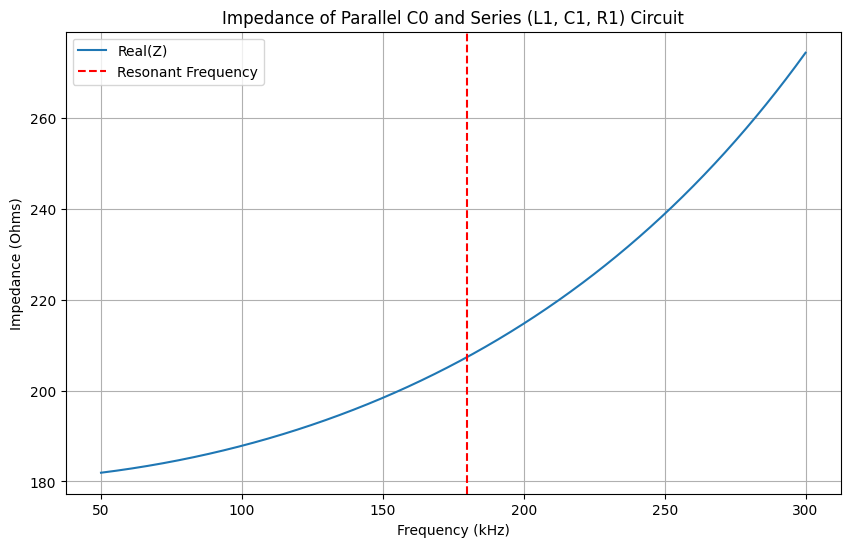

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Given specs
f_resonant = 180e3  # 180 kHz
# Component values
C0 = 1.38e-12  # pFarads
L1 = 387.63e-4  # uHenrys
C1 = 2.18e-4  # nFarads
R1 = 180     # Ohms

print(f"Chosen L1 = {L1*1e6:.3f} uH, C1 = {C1*1e9:.2f} nF, C0 = {C0*1e9:.2f} nF")

# Frequency range for plotting
f = np.linspace(50e3, 300e3, 1000)  # 50kHz to 300kHz
omega = 2 * np.pi * f

# Impedances
Z_C0 = 1 / (1j * omega * C0)

Z_series = R1 + 1j * omega * L1 + 1 / (1j * omega * C1)

# Total impedance: parallel combination
Z_total = 1 / (1/Z_C0 + 1/Z_series)

# Plotting
plt.figure(figsize=(10,6))
plt.plot(f/1e3, Z_total.real, label='Real(Z)')
#plt.plot(f/1e3, Z_total.imag, label='Imag(Z)')
plt.axvline(f_resonant/1e3, color='red', linestyle='--', label='Resonant Frequency')
plt.title('Impedance of Parallel C0 and Series (L1, C1, R1) Circuit')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Impedance (Ohms)')
plt.grid(True)
plt.legend()
plt.show()


Maximum Q = 49121.90 at:
C1 = 0.1000 pF
L1 = 7817992.5650 uH
Fixed R1 = 180 Ohms, Resonant freq = 180.0 kHz


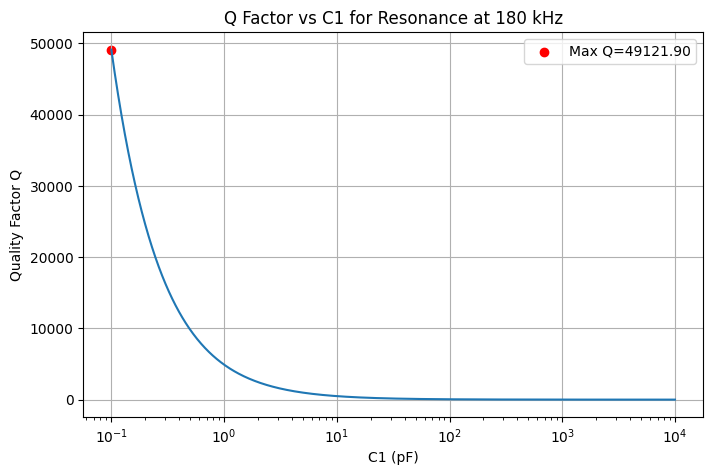

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Given constants
f_resonant = 180e3  # Hz
R1 = 180  # Ohms
C0 = 1.38e-9  # Fixed parallel capacitor (F)

# Resonant frequency omega0
omega0 = 2 * np.pi * f_resonant

# Sweep C1 from 0.1 pF to 10 nF logarithmically
C1_values = np.logspace(-13, -8, 1000)  # in Farads

# Calculate corresponding L1 to maintain resonance
L1_values = 1 / (omega0**2 * C1_values)

# Calculate Q factor for each
Q_values = (1 / R1) * np.sqrt(L1_values / C1_values)  # or Q = 1/(R1) * 1/(omega0 * C1)

# Find max Q and corresponding components
max_idx = np.argmax(Q_values)
max_Q = Q_values[max_idx]
best_C1 = C1_values[max_idx]
best_L1 = L1_values[max_idx]

print(f"Maximum Q = {max_Q:.2f} at:")
print(f"C1 = {best_C1*1e12:.4f} pF")
print(f"L1 = {best_L1*1e6:.4f} uH")
print(f"Fixed R1 = {R1} Ohms, Resonant freq = {f_resonant/1e3} kHz")

# Plot Q vs C1
plt.figure(figsize=(8,5))
plt.semilogx(C1_values*1e12, Q_values)
plt.scatter(best_C1*1e12, max_Q, color='red', label=f'Max Q={max_Q:.2f}')
plt.xlabel('C1 (pF)')
plt.ylabel('Quality Factor Q')
plt.title('Q Factor vs C1 for Resonance at 180 kHz')
plt.grid(True)
plt.legend()
plt.show()


In [7]:
import numpy as np

# Assume f_band and Z_meas_band.real are numpy arrays

def estimate_q_factor(f_band, Z_real):
    peak_idx = np.argmax(Z_real)
    f0 = f_band[peak_idx]
    peak_val = Z_real[peak_idx]
    half_power = peak_val / np.sqrt(2)
    
    # Find lower frequency at half power
    lower_idx = np.where(Z_real[:peak_idx] <= half_power)[0]
    if len(lower_idx) == 0:
        f1 = f_band[0]
    else:
        f1 = f_band[lower_idx[-1]]
    
    # Find higher frequency at half power
    upper_idx = np.where(Z_real[peak_idx:] <= half_power)[0]
    if len(upper_idx) == 0:
        f2 = f_band[-1]
    else:
        f2 = f_band[peak_idx + upper_idx[0]]
    
    bandwidth = f2 - f1
    Q = f0 / bandwidth if bandwidth != 0 else np.inf
    
    print(f"Resonant frequency f0 = {f0/1e3:.2f} kHz")
    print(f"Bandwidth Δf = {bandwidth/1e3:.2f} kHz")
    print(f"Estimated Q factor = {Q:.2f}")
    return Q

# Example usage:
Q = estimate_q_factor(f_band, Z_meas_band.real)


Resonant frequency f0 = 186.97 kHz
Bandwidth Δf = 8.91 kHz
Estimated Q factor = 20.98


180 0.038763 0.000218 1.38e-09


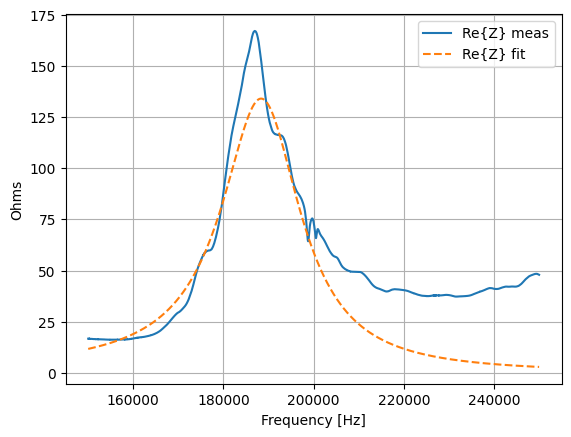

In [ ]:
import numpy as np
from scipy.optimize import least_squares

# Expect: f (Hz), Z_meas (complex ndarray, same length)
def fit_C0_parallel_series_RLC(f, Z_meas, seeds=None, bounds=None, logparam=True):

    w = 2*np.pi*f
    Y_meas = 1.0 / Z_meas
    y_target = np.concatenate([Y_meas.real, Y_meas.imag])

    # Heuristic seeds if not provided
    if seeds is None:
        # crude f0 from max Re{Z}
        i_peak = np.argmax(Z_meas.real)
        f0 = f[i_peak]
        w0 = 2*np.pi*f0
        Q = max(10.0, min(100.0, (f0 / max(1.0, 0.5*(f[np.argmax(Z_meas.real)] - f[np.argmin(Z_meas.real)])))) )  # fallback; replace if you know Q
        C1 = 1e-9           # pick a decade you think is right (tune this!)
        L1 = 1.0 / ((w0**2) * C1)
        R1 = w0 * L1 / 21.0 # use your measured Q≈21
        # C0 estimate from high-f point
        k = int(0.9*len(f))
        C0 = max(1e-13, -1.0/( (2*np.pi*f[k]) * Z_meas.imag[k] ))
        seeds = np.array([R1, L1, C1, C0])

    if bounds is None:
        lo = np.array([1e-3, 1e-9, 1e-12, 1e-13])
        hi = np.array([1e4, 1e-1, 1e-7, 1e-6])
        bounds = (lo, hi)

    def pack(x):
        return np.log(x) if logparam else x

    def unpack(p):
        return np.exp(p) if logparam else p

    p0 = pack(seeds)
    lo, hi = bounds
    lb = pack(lo)
    ub = pack(hi)

    def residuals(p):
        R1, L1, C1, C0 = unpack(p)
        wC1 = w * C1
        # Z_s = R1 + j*w*L1 + 1/(j*w*C1)
        Zs_real = R1
        Zs_imag = w*L1 - 1.0/(w*C1)
        denom = Zs_real**2 + Zs_imag**2
        Ys_real = Zs_real / denom
        Ys_imag = -Zs_imag / denom
        Y_real = Ys_real
        Y_imag = w*C0 + Ys_imag
        y_model = np.concatenate([Y_real, Y_imag])
        return y_model - y_target

    res = least_squares(residuals, p0, bounds=(lb, ub), method='trf', xtol=1e-12, ftol=1e-12, gtol=1e-12, max_nfev=2000)
    R1, L1, C1, C0 = unpack(res.x)
    return {"R1": R1, "L1": L1, "C1": C1, "C0": C0, "res": res}

def model_Z(f, R1, L1, C1, C0):
    w = 2*np.pi*f
    Zs = R1 + 1j*w*L1 + 1/(1j*w*C1)
    Y = 1j*w*C0 + 1/Zs
    return 1/Y

pars = fit_C0_parallel_series_RLC(f_band, Z_meas_band)
Z_fit = model_Z(f_band, **{k:pars[k] for k in ["R1","L1","C1","C0"]})

print(R1, L1, C1, C0)

# Inspect resonance
import matplotlib.pyplot as plt
plt.figure()
plt.plot(f_band, Z_meas_band.real, label="Re{Z} meas")
plt.plot(f_band, Z_fit.real,  linestyle="--", label="Re{Z} fit")
plt.xlabel("Frequency [Hz]"); plt.ylabel("Ohms"); plt.legend(); plt.grid(True)
plt.show()


Fitted params: {'R1': 154.0226176229289, 'L1': 0.0009028299079294234, 'C1': 8.925522718730972e-10, 'C0': 5.80213785840511e-09}
RMSE Re{Z}: 21.01227055318088


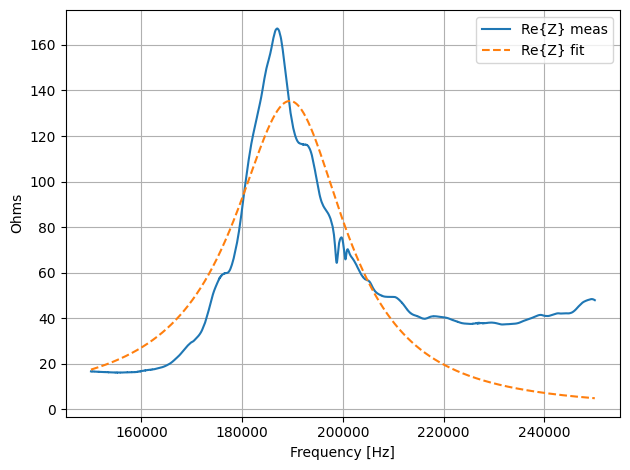

In [ ]:
import numpy as np
from dataclasses import dataclass, asdict
from typing import Callable, Dict, Optional, Tuple, Literal
from scipy.optimize import least_squares


# ---------- Model data structure ----------

@dataclass
class Params:
    """Series RLC (R1, L1, C1) in parallel with C0."""
    R1: float
    L1: float
    C1: float
    C0: float

    def to_array(self) -> np.ndarray:
        return np.array([self.R1, self.L1, self.C1, self.C0], dtype=float)

    @staticmethod
    def from_array(x: np.ndarray) -> "Params":
        return Params(R1=float(x[0]), L1=float(x[1]), C1=float(x[2]), C0=float(x[3]))


# ---------- Core circuit relations ----------

def Z_series_RLC(w: np.ndarray, R1: float, L1: float, C1: float) -> np.ndarray:
    """Impedance of series R-L-C."""
    return R1 + 1j*w*L1 + 1/(1j*w*C1)

def Z_model(f: np.ndarray, p: Params) -> np.ndarray:
    """Total impedance: (series RLC) || C0."""
    w = 2*np.pi*f
    Zs = Z_series_RLC(w, p.R1, p.L1, p.C1)
    Y = 1j*w*p.C0 + 1/Zs
    return 1 / Y

def Y_model(f: np.ndarray, p: Params) -> np.ndarray:
    """Total admittance (sometimes numerically nicer to fit in Y-domain)."""
    return 1 / Z_model(f, p)


# ---------- Objectives & metrics ----------

def rmse_real_Z(f: np.ndarray, Z_meas: np.ndarray, p: Params) -> float:
    """RMSE of real part of Z."""
    err = (Z_model(f, p).real - Z_meas.real)
    return float(np.sqrt(np.mean(err**2)))

def stack_residual(
    f: np.ndarray,
    Z_meas: np.ndarray,
    p: Params,
    target: Literal["Y_both","Z_both","Z_real","Z_imag"] = "Y_both",
    weights: Optional[Tuple[float, float]] = None,
) -> np.ndarray:
    """
    Build residual vector per chosen target.
    - Y_both: [Re{Y}, Im{Y}]  (matches your original formulation)
    - Z_both: [Re{Z}, Im{Z}]
    - Z_real: Re{Z} only
    - Z_imag: Im{Z} only
    weights=(wr, wi) apply to the respective stacked parts when both are present.
    """
    if target == "Y_both":
        Ym = 1 / Z_meas
        Yhat = Y_model(f, p)
        r = Yhat.real - Ym.real
        i = Yhat.imag - Ym.imag
        if weights:
            wr, wi = weights
            return np.concatenate([wr*r, wi*i])
        return np.concatenate([r, i])

    Zhat = Z_model(f, p)
    if target == "Z_both":
        r = Zhat.real - Z_meas.real
        i = Zhat.imag - Z_meas.imag
        if weights:
            wr, wi = weights
            return np.concatenate([wr*r, wi*i])
        return np.concatenate([r, i])
    elif target == "Z_real":
        return Zhat.real - Z_meas.real
    elif target == "Z_imag":
        return Zhat.imag - Z_meas.imag
    else:
        raise ValueError(f"Unknown target='{target}'")


# ---------- Parameter transforms ----------

def _pack(x: np.ndarray, logparam: bool) -> np.ndarray:
    return np.log(x) if logparam else x

def _unpack(p: np.ndarray, logparam: bool) -> np.ndarray:
    return np.exp(p) if logparam else p


# ---------- Seed estimation (lightweight, deterministic) ----------

def estimate_seeds(
    f: np.ndarray,
    Z_meas: np.ndarray,
    C1_guess: float = 1e-9,
    Q_guess: float = 20.0,
) -> Params:
    """
    Very crude seeds:
    - f0 from max(Re{Z}) (you can swap to argmin(Im{Z}) or phase=0 crossing if preferred)
    - L1 from w0^-2 * C1_guess
    - R1 from Q≈w0*L1/R1  -> R1 ≈ w0*L1/Q_guess
    - C0 from high-frequency point using Im{Z} ≈ -1/(w*C0) (parallel cap dominant)
    """
    i_peak = int(np.argmax(Z_meas.real))
    f0 = max(1.0, float(f[i_peak]))
    w0 = 2*np.pi*f0

    C1 = float(C1_guess)
    L1 = 1.0 / (w0**2 * C1)
    R1 = w0 * L1 / max(1.0, Q_guess)

    k = max(0, min(len(f)-1, int(0.9*len(f))))
    C0_est = -1.0 / ( (2*np.pi*f[k]) * Z_meas.imag[k] )
    C0 = max(1e-13, float(C0_est))

    return Params(R1=R1, L1=L1, C1=C1, C0=C0)


# ---------- Fitting ----------

def fit_RLC_parallel_C0(
    f: np.ndarray,
    Z_meas: np.ndarray,
    seeds: Optional[Params] = None,
    bounds: Optional[Tuple[np.ndarray, np.ndarray]] = None,
    logparam: bool = True,
    target: Literal["Y_both","Z_both","Z_real","Z_imag"] = "Y_both",
    weights: Optional[Tuple[float, float]] = None,
    max_nfev: int = 2000,
    tol: float = 1e-12,
):
    """
    Fit R1, L1, C1, C0 for (series RLC) || C0.

    Parameters
    ----------
    target:
        Choose the residual definition:
        - "Y_both": stack [Re{Y}, Im{Y}] (original)
        - "Z_both": stack [Re{Z}, Im{Z}]
        - "Z_real": Re{Z} only
        - "Z_imag": Im{Z} only
    weights:
        (wr, wi) for the two stacked parts when using a *_both target.
    """
    # Seeds
    if seeds is None:
        seeds = estimate_seeds(f, Z_meas)

    x0 = seeds.to_array()

    # Bounds
    if bounds is None:
        lo = np.array([1e-3, 1e-9, 1e-12, 1e-13], dtype=float)
        hi = np.array([1e4,  1e-1, 1e-7,  1e-6 ], dtype=float)
        bounds = (lo, hi)

    p0 = _pack(x0, logparam=logparam)
    lb = _pack(bounds[0], logparam=logparam)
    ub = _pack(bounds[1], logparam=logparam)

    def _res(packed: np.ndarray) -> np.ndarray:
        x = _unpack(packed, logparam=logparam)
        p = Params.from_array(x)
        return stack_residual(f, Z_meas, p, target=target, weights=weights)

    res = least_squares(
        _res, p0, bounds=(lb, ub), method="trf",
        xtol=tol, ftol=tol, gtol=tol, max_nfev=max_nfev
    )

    x_opt = _unpack(res.x, logparam=logparam)
    p_opt = Params.from_array(x_opt)
    return {"params": p_opt, "result": res}


# ---------- Convenience plotting (optional) ----------

def plot_fit_Z_real(f: np.ndarray, Z_meas: np.ndarray, Z_fit: np.ndarray):
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(f, Z_meas.real, label="Re{Z} meas")
    plt.plot(f, Z_fit.real, linestyle="--", label="Re{Z} fit")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Ohms")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ---------- Example usage (comment out as needed) ----------

if __name__ == "__main__":
    # Expect f_band (Hz) and Z_meas_band (complex ndarray) to be defined by you.
    # Fit using original Y-domain both-parts residual:
    # fit = fit_RLC_parallel_C0(f_band, Z_meas_band, target="Y_both", logparam=True)
    # Or, if you want RMSE on Re{Z} specifically:
    # fit = fit_RLC_parallel_C0(f_band, Z_meas_band, target="Z_real", logparam=True)

    # Example (uncomment when f_band, Z_meas_band exist):
    fit = fit_RLC_parallel_C0(f_band, Z_meas_band, target="Z_real", logparam=True)
    p = fit["params"]
    print("Fitted params:", asdict(p))
    Z_fit = Z_model(f_band, p)
    print("RMSE Re{Z}:", rmse_real_Z(f_band, Z_meas_band, p))
    plot_fit_Z_real(f_band, Z_meas_band, Z_fit)
    pass


447.91748878783204


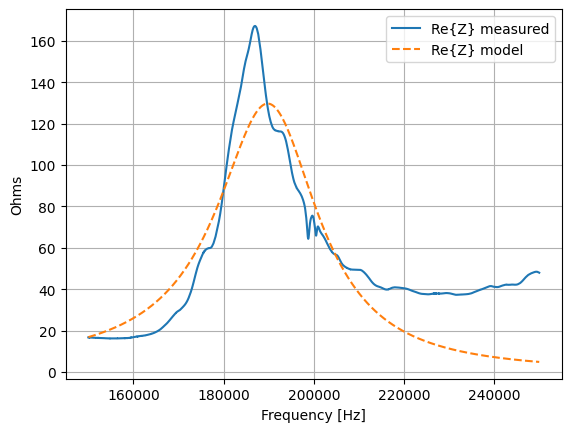

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# --- Adjustable parameters ---
R1 = 155.0       # Ohms
L1 = 900e-6      # Henries
C1 = 0.89e-9       # Farads
C0 = 5.9e-09     # Farads

# --- Model ---
def model_Z(f, R1, L1, C1, C0):
    w = 2 * np.pi * f
    Zs = R1 + 1j*w*L1 + 1/(1j*w*C1)  # series RLC
    Y_total = 1j*w*C0 + 1/Zs         # parallel C0
    return 1 / Y_total

# --- Compute model curve ---
Z_fit = model_Z(f_band, R1, L1, C1, C0)

MSE = mean_squared_error(Z_meas_band.real, Z_fit.real)

print(MSE)

# --- Plot ---
plt.figure()
plt.plot(f_band, Z_meas_band.real, label="Re{Z} measured")
plt.plot(f_band, Z_fit.real, '--', label="Re{Z} model")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Ohms")
plt.legend()
plt.grid(True)
plt.show()


# Brute force search

Best MSE: 753.9881156131103
Best parameters:
  R1 = 209.25 Ohm
  L1 = 0.000855 H
  C1 = 9.345e-10 F
  C0 = 5.31e-09 F


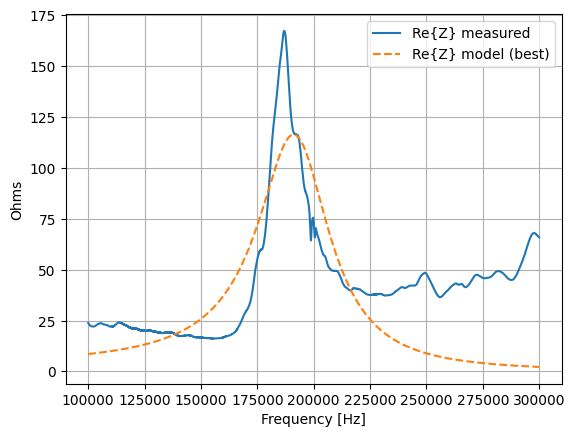

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# --- Initial guesses (from you) ---
R1_0 = 155.0        # Ohms
L1_0 = 900e-6       # H
C1_0 = 0.89e-9      # F
C0_0 = 5.9e-9       # F

# --- Model ---
def model_Z(f, R1, L1, C1, C0):
    w = 2 * np.pi * f
    Zs = R1 + 1j*w*L1 + 1/(1j*w*C1)   # series RLC
    Y_total = 1j*w*C0 + 1/Zs          # parallel C0
    return 1 / Y_total

# --- Search grids (very simple, coarse) ---
R1_grid = np.linspace(R1_0*0.5, R1_0*1.5, 21)          # 21 points
L1_grid = np.linspace(L1_0*0.5, L1_0*1.5, 21)
C1_grid = np.linspace(C1_0*0.5, C1_0*1.5, 21)
C0_grid = np.linspace(C0_0*0.5, C0_0*1.5, 21)

best_mse = np.inf
best_params = (R1_0, L1_0, C1_0, C0_0)
best_fit = None

# --- Naive nested loops ---
for R1 in R1_grid:
    for L1 in L1_grid:
        for C1 in C1_grid:
            for C0 in C0_grid:
                Z_fit = model_Z(f_band, R1, L1, C1, C0)
                mse = mean_squared_error(Z_meas_band.real, Z_fit.real)
                if mse < best_mse:
                    best_mse = mse
                    best_params = (R1, L1, C1, C0)
                    best_fit = Z_fit

print("Best MSE:", best_mse)
print("Best parameters:")
print(f"  R1 = {best_params[0]:.6g} Ohm")
print(f"  L1 = {best_params[1]:.6g} H")
print(f"  C1 = {best_params[2]:.6g} F")
print(f"  C0 = {best_params[3]:.6g} F")

# --- Plot ---
plt.figure()
plt.plot(f_band, Z_meas_band.real, label="Re{Z} measured")
plt.plot(f_band, best_fit.real, '--', label="Re{Z} model (best)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Ohms")
plt.legend()
plt.grid(True)
plt.show()


# Dmg state

Best MSE: 707.7586997210116
Best parameters:
  R1 = 201.5 Ohm
  L1 = 0.0009 H
  C1 = 8.9e-10 F
  C0 = 5.31e-09 F


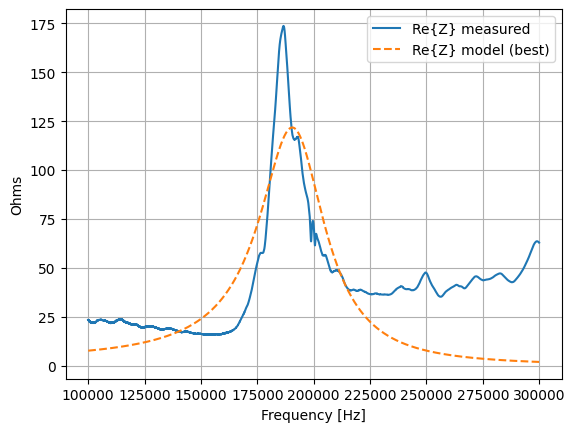

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# --- Initial guesses (from you) ---
R1_0 = 155.0        # Ohms
L1_0 = 900e-6       # H
C1_0 = 0.89e-9      # F
C0_0 = 5.9e-9       # F

# --- Model ---
def model_Z(f, R1, L1, C1, C0):
    w = 2 * np.pi * f
    Zs = R1 + 1j*w*L1 + 1/(1j*w*C1)   # series RLC
    Y_total = 1j*w*C0 + 1/Zs          # parallel C0
    return 1 / Y_total

# --- Search grids (very simple, coarse) ---
R1_grid = np.linspace(R1_0*0.5, R1_0*1.5, 21)          # 21 points
L1_grid = np.linspace(L1_0*0.5, L1_0*1.5, 21)
C1_grid = np.linspace(C1_0*0.5, C1_0*1.5, 21)
C0_grid = np.linspace(C0_0*0.5, C0_0*1.5, 21)

best_mse = np.inf
best_params = (R1_0, L1_0, C1_0, C0_0)
best_fit = None

# --- Naive nested loops ---
for R1 in R1_grid:
    for L1 in L1_grid:
        for C1 in C1_grid:
            for C0 in C0_grid:
                Z_fit = model_Z(f_band, R1, L1, C1, C0)
                mse = mean_squared_error(Z_meas_band.real, Z_fit.real)
                if mse < best_mse:
                    best_mse = mse
                    best_params = (R1, L1, C1, C0)
                    best_fit = Z_fit

print("Best MSE:", best_mse)
print("Best parameters:")
print(f"  R1 = {best_params[0]:.6g} Ohm")
print(f"  L1 = {best_params[1]:.6g} H")
print(f"  C1 = {best_params[2]:.6g} F")
print(f"  C0 = {best_params[3]:.6g} F")

# --- Plot ---
plt.figure()
plt.plot(f_band, Z_meas_band.real, label="Re{Z} measured")
plt.plot(f_band, best_fit.real, '--', label="Re{Z} model (best)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Ohms")
plt.legend()
plt.grid(True)
plt.show()



In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# --- Initial guesses (from you) ---
R1_0 = 155.0        # Ohms
L1_0 = 900e-6       # H
C1_0 = 0.89e-9      # F
C0_0 = 5.9e-9       # F

# --- Precompute once ---
w = 2 * np.pi * f_band
jw = 1j * w
Z_meas_real = Z_meas_band.real

def model_Z(f_w, R1, L1, C1, C0):
    # f_w is w=2πf (already precomputed)
    jw = 1j * f_w
    Zs = R1 + jw*L1 + 1/(jw*C1)      # series RLC
    Y_total = jw*C0 + 1/Zs           # parallel C0
    return 1 / Y_total

def mse_real(Z_fit_real):
    # mean_squared_error without sklearn overhead in the tight loop
    diff = Z_meas_real - Z_fit_real
    return np.mean(diff*diff)

def grid_search_two_stage(
    center,               # (R1, L1, C1, C0)
    widths1, steps1,      # coarse stage: widths (±fraction of center) and steps
    widths2, steps2       # fine stage: same
):
    # --- Stage helper ---
    def run_stage(center_vals, widths, steps):
        R1_c, L1_c, C1_c, C0_c = center_vals
        # Build 1D grids for outer two (R1,L1)
        R1_grid = np.linspace(R1_c*(1-widths[0]), R1_c*(1+widths[0]), steps[0])
        L1_grid = np.linspace(L1_c*(1-widths[1]), L1_c*(1+widths[1]), steps[1])
        # Build 1D grids for inner two (C1,C0) for broadcasting
        C1_grid = np.linspace(C1_c*(1-widths[2]), C1_c*(1+widths[2]), steps[2])
        C0_grid = np.linspace(C0_c*(1-widths[3]), C0_c*(1+widths[3]), steps[3])

        # Prepare broadcast shapes: (freq, 1, 1, Nc1, Nc0)
        C1v = C1_grid[None, None, None, :, None]
        C0v = C0_grid[None, None, None, None, :]

        best = {
            "mse": np.inf,
            "params": tuple(center_vals),
            "Z_fit": None
        }

        # Loop only over R1, L1 (keeps it “naive” but much cheaper)
        for R1 in R1_grid:
            for L1 in L1_grid:
                # Compute Zs for all (C1,C0) at once with broadcasting
                # Shapes:
                # w: (Nf,) -> (Nf,1,1,1,1)
                jwv = 1j * w[:, None, None, None, None]

                Zs = R1 + jwv*L1 + 1/(jwv*C1v)              # (Nf,1,1,Nc1,1)
                Y_total = jwv*C0v + 1/Zs                    # (Nf,1,1,Nc1,Nc0)
                Z_fit = 1 / Y_total                         # (Nf,1,1,Nc1,Nc0)

                # Real part and MSE over frequency axis
                Zr = Z_fit.real[:, 0, 0, :, :]              # (Nf, Nc1, Nc0)
                diff = Z_meas_real[:, None, None] - Zr
                mse_mat = np.mean(diff*diff, axis=0)        # (Nc1, Nc0)

                # Find best (C1,C0) for this (R1,L1)
                idx = np.unravel_index(np.argmin(mse_mat), mse_mat.shape)
                mse_val = mse_mat[idx]
                C1_best = C1_grid[idx[0]]
                C0_best = C0_grid[idx[1]]

                if mse_val < best["mse"]:
                    best["mse"] = mse_val
                    best["params"] = (R1, L1, C1_best, C0_best)
                    # Keep the corresponding Z_fit (recompute once for the best)
                    Z_best = model_Z(w, R1, L1, C1_best, C0_best)
                    best["Z_fit"] = Z_best

        return best

    # --- Stage 1: coarse ---
    best1 = run_stage(center, widths1, steps1)
    # --- Stage 2: fine around best1 ---
    best2 = run_stage(best1["params"], widths2, steps2)
    return best2

# --- Choose simple, fast settings ---
# Coarse: ±50% range, small step counts
widths1 = (0.5, 0.5, 0.5, 0.5)          # fractional ± ranges for (R1,L1,C1,C0)
steps1 = (15, 15, 25, 25)  # coarse stage, more points

# Fine: ±10% range, denser
widths2 = (0.1, 0.1, 0.2, 0.2)
steps2 = (21, 21, 31, 31)  # fine stage, even more points

best = grid_search_two_stage((R1_0, L1_0, C1_0, C0_0), widths1, steps1, widths2, steps2)

print("Best MSE:", best["mse"])
R1_b, L1_b, C1_b, C0_b = best["params"]
print(f"Best parameters:\n  R1 = {R1_b:.6g} Ω\n  L1 = {L1_b:.6g} H\n  C1 = {C1_b:.6g} F\n  C0 = {C0_b:.6g} F")

# --- Plot ---
plt.figure()
plt.plot(f_band, Z_meas_band.real, label="Re{Z} measured")
plt.plot(f_band, best["Z_fit"].real, '--', label="Re{Z} model (best)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Ohms")
plt.legend()
plt.grid(True)
plt.show()


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# --- Initial guesses (from you) ---
R1_0 = 155.0        # Ohms
L1_0 = 900e-6       # H
C1_0 = 0.89e-9      # F
C0_0 = 5.9e-9       # F

# --- Precompute once ---
w = 2 * np.pi * f_band
jw = 1j * w
Z_meas_real = Z_meas_band.real

def model_Z(f_w, R1, L1, C1, C0):
    # f_w is w=2πf (already precomputed)
    jw = 1j * f_w
    Zs = R1 + jw*L1 + 1/(jw*C1)      # series RLC
    Y_total = jw*C0 + 1/Zs           # parallel C0
    return 1 / Y_total

def mse_real(Z_fit_real):
    # mean_squared_error without sklearn overhead in the tight loop
    diff = Z_meas_real - Z_fit_real
    return np.mean(diff*diff)

def grid_search_two_stage(
    center,               # (R1, L1, C1, C0)
    widths1, steps1,      # coarse stage: widths (±fraction of center) and steps
    widths2, steps2       # fine stage: same
):
    # --- Stage helper ---
    def run_stage(center_vals, widths, steps):
        R1_c, L1_c, C1_c, C0_c = center_vals
        # Build 1D grids for outer two (R1,L1)
        R1_grid = np.linspace(R1_c*(1-widths[0]), R1_c*(1+widths[0]), steps[0])
        L1_grid = np.linspace(L1_c*(1-widths[1]), L1_c*(1+widths[1]), steps[1])
        # Build 1D grids for inner two (C1,C0) for broadcasting
        C1_grid = np.linspace(C1_c*(1-widths[2]), C1_c*(1+widths[2]), steps[2])
        C0_grid = np.linspace(C0_c*(1-widths[3]), C0_c*(1+widths[3]), steps[3])

        # Prepare broadcast shapes: (freq, 1, 1, Nc1, Nc0)
        C1v = C1_grid[None, None, None, :, None]
        C0v = C0_grid[None, None, None, None, :]

        best = {
            "mse": np.inf,
            "params": tuple(center_vals),
            "Z_fit": None
        }

        # Loop only over R1, L1 (keeps it “naive” but much cheaper)
        for R1 in R1_grid:
            for L1 in L1_grid:
                # Compute Zs for all (C1,C0) at once with broadcasting
                # Shapes:
                # w: (Nf,) -> (Nf,1,1,1,1)
                jwv = 1j * w[:, None, None, None, None]

                Zs = R1 + jwv*L1 + 1/(jwv*C1v)              # (Nf,1,1,Nc1,1)
                Y_total = jwv*C0v + 1/Zs                    # (Nf,1,1,Nc1,Nc0)
                Z_fit = 1 / Y_total                         # (Nf,1,1,Nc1,Nc0)

                # Real part and MSE over frequency axis
                Zr = Z_fit.real[:, 0, 0, :, :]              # (Nf, Nc1, Nc0)
                diff = Z_meas_real[:, None, None] - Zr
                mse_mat = np.mean(diff*diff, axis=0)        # (Nc1, Nc0)

                # Find best (C1,C0) for this (R1,L1)
                idx = np.unravel_index(np.argmin(mse_mat), mse_mat.shape)
                mse_val = mse_mat[idx]
                C1_best = C1_grid[idx[0]]
                C0_best = C0_grid[idx[1]]

                if mse_val < best["mse"]:
                    best["mse"] = mse_val
                    best["params"] = (R1, L1, C1_best, C0_best)
                    # Keep the corresponding Z_fit (recompute once for the best)
                    Z_best = model_Z(w, R1, L1, C1_best, C0_best)
                    best["Z_fit"] = Z_best

        return best

    # --- Stage 1: coarse ---
    best1 = run_stage(center, widths1, steps1)
    # --- Stage 2: fine around best1 ---
    best2 = run_stage(best1["params"], widths2, steps2)
    return best2

# --- Choose simple, fast settings ---
# Coarse: ±50% range, small step counts
widths1 = (0.5, 0.5, 0.5, 0.5)          # fractional ± ranges for (R1,L1,C1,C0)
steps1 = (15, 15, 25, 25)  # coarse stage, more points

# Fine: ±10% range, denser
widths2 = (0.1, 0.1, 0.2, 0.2)
steps2 = (21, 21, 31, 31)  # fine stage, even more points

best = grid_search_two_stage((R1_0, L1_0, C1_0, C0_0), widths1, steps1, widths2, steps2)

print("Best MSE:", best["mse"])
R1_b, L1_b, C1_b, C0_b = best["params"]
print(f"Best parameters:\n  R1 = {R1_b:.6g} Ω\n  L1 = {L1_b:.6g} H\n  C1 = {C1_b:.6g} F\n  C0 = {C0_b:.6g} F")

# --- Plot ---
plt.figure()
plt.plot(f_band, Z_meas_band.real, label="Re{Z} measured")
plt.plot(f_band, best["Z_fit"].real, '--', label="Re{Z} model (best)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Ohms")
plt.legend()
plt.grid(True)
plt.show()